[0] WARNING  pylbm.scheme in function _check_inverse line 384
Problem M * invM is not identity !!!


Reynolds number  2.000e+00
0.015625


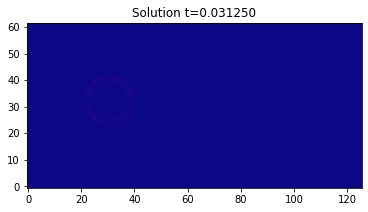

In [2]:
import numpy as np
import sympy as sp
import pylbm
import sys

"""

Von Karman vortex street simulated by Navier-Stokes solver D2Q9

Reynolds number = 250

"""
def printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        barLength   - Optional  : character length of bar (Int)
    """
    formatStr       = "{0:." + str(decimals) + "f}"
    percents        = formatStr.format(100 * (iteration / float(total)))
    filledLength    = int(round(barLength * iteration / float(total)))
    bar             = '*' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
    sys.stdout.flush()
    if iteration == total:
        sys.stdout.write('\n')
        sys.stdout.flush()

h5_save = False

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy = sp.symbols('rho, qx, qy')

def bc_rect(f, m, x, y, rhoo, uo):
    m[rho] = 0.
    m[qx] = rhoo*uo
    m[qy] = 0.

def vorticity(sol):
    qx_n = sol.m[qx]
    qy_n = sol.m[qy]
    vort = np.abs(qx_n[1:-1, 2:] - qx_n[1:-1, :-2]
                  - qy_n[2:, 1:-1] + qy_n[:-2, 1:-1])
    return vort.T

def save(mpi_topo, x, y, m, num):
    h5 = pylbm.H5File(mpi_topo, filename, path, num)
    h5.set_grid(x, y)
    h5.add_scalar('rho', m[rho])
    h5.add_vector('velocity', [m[qx], m[qy]])
    h5.save()
    

# parameters
xmin, xmax, ymin, ymax = 0., 2., 0., 1.
radius = 0.125
if h5_save:
    dx = 1./512 # spatial step
else:
    dx = 1./64
la = 1. # velocity of the scheme
rhoo = 1.
uo = 0.004
mu = 5.e-4
zeta = 10*mu
dummy = 3.0/(la*rhoo*dx)
s1 = 1.0/(0.5+zeta*dummy)
s2 = 1.0/(0.5+mu*dummy)
s  = [0.,0.,0.,s1,s1,s1,s1,s2,s2]
dummy = 1./(LA**2*rhoo)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy



dico = {
    'box': {
        'x': [xmin, xmax],
        'y': [ymin, ymax],
        'label': [0, 1, 0, 0]
    },
    'elements': [pylbm.Circle([.5, 0.5*(ymin+ymax)+2*dx], radius, label=2)],
    'space_step': dx,
    'scheme_velocity': LA,
    'schemes': [
        {
            'velocities': list(range(9)),
            'polynomials': [
                1,
                LA*X, LA*Y,
                3*(X**2+Y**2)-4,
                0.5*(9*(X**2+Y**2)**2-21*(X**2+Y**2)+8),
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters': s,
            'equilibrium': [
                rho,
                qx, qy,
                -2*rho + 3*q2,
                rho - 3*q2,
                -qx/LA, -qy/LA,
                qx2 - qy2, qxy
            ],
            'conserved_moments': [rho, qx, qy],
        },
    ],
    'init': {rho: rhoo,
             qx: rhoo*uo,
             qy: 0.
    },
    'parameters': {LA: la},
    'boundary_conditions': {
        0: {'method': {0: pylbm.bc.BouzidiBounceBack}, 'value': (bc_rect, (rhoo, uo))},
        1: {'method': {0: pylbm.bc.NeumannX}},
        2: {'method': {0: pylbm.bc.BouzidiBounceBack}},
    },
    'generator': "cython",
}

sol = pylbm.Simulation(dico)

Re = rhoo*uo*2*radius/mu
print("Reynolds number {0:10.3e}".format(Re))

x, y = sol.domain.x, sol.domain.y
print(sol.dt)
numpy_save = False

if h5_save:
    Tf = 500.
    im = 0
    l = Tf / sol.dt / 64
    printProgress(im, l, prefix='Progress:', suffix='Complete', barLength=50)
    filename = 'Karman'
    path = './data_' + filename
    #save(sol.mpi_topo, x, y, sol.m, im)
    e = np.zeros()
    while sol.t < Tf:
        for k in range(64):
            print(sol.t)
            sol.one_time_step()
        im += 1
        printProgress(im, l, prefix='Progress:', suffix='Complete', barLength=50)
        
        save(sol.mpi_topo, x, y, sol.m, im)
elif numpy_save:
    Tf = 250.
    im = 0
    l = Tf / sol.dt / 64
    printProgress(im, l, prefix='Progress:', suffix='Complete', barLength=50)
    filename = 'Re_' + str(int(Re))
    path = '.timestep_exploration' + filename
    #save(sol.mpi_topo, x, y, sol.m, im)

    first = True
    
    while sol.t < Tf:
        for k in range(64):
#             print(sol.dt)
            print(sol.t)
            sol.one_time_step()
        im += 1
        printProgress(im, l, prefix='Progress:', suffix='Complete', barLength=50)
        
        if first:
            vx_map = sol.m[qx][:,:,np.newaxis]
            vy_map = sol.m[qy][:,:,np.newaxis]
            rho_map = sol.m[rho][:,:,np.newaxis]
            first = False
        else:
            vx_map = np.dstack((vx_map, sol.m[qx]))
            vy_map = np.dstack((vy_map, sol.m[qy]))
            rho_map = np.dstack((rho_map, sol.m[rho]))
            
    np.savez(filename,vx=vx_map, vy=vy_map, rho=rho_map)
    
elif h5_save:
    Tf = 250.
    im = 0
    l = Tf / sol.dt / 64
    printProgress(im, l, prefix='Progress:', suffix='Complete', barLength=50)
    filename = 'Re_' + str(int(Re))
    path = './data_' + filename
    #save(sol.mpi_topo, x, y, sol.m, im)

    first = True
    
    while sol.t < Tf:
        for k in range(64):
            sol.one_time_step()
        im += 1
        printProgress(im, l, prefix='Progress:', suffix='Complete', barLength=50)
        
        if first:
            vx_map = sol.m[qx][:,:,np.newaxis]
            vy_map = sol.m[qy][:,:,np.newaxis]
            rho_map = sol.m[rho][:,:,np.newaxis]
            first = False
        else:
            vx_map = np.dstack((vx_map, sol.m[qx]))
            vy_map = np.dstack((vy_map, sol.m[qy]))
            rho_map = np.dstack((rho_map, sol.m[rho]))
            
    np.savez(filename,vx=vx_map, vy=vy_map, rho=rho_map)
    
else:
    viewer = pylbm.viewer.matplotlib_viewer
    fig = viewer.Fig()
    ax = fig[0]
    #ax.ellipse([.3/dx, 0.5*(ymin+ymax)/dx+2], [radius/dx, radius/dx], 'r')
    image = ax.image(vorticity(sol), cmap='plasma', clim=[0, .1])
    epsilon = 1e-3
    prev_x = sol.m[qx]
    prev_y = sol.m[qy]
    

    def update(iframe):
        nrep = 2
        for i in range(nrep):
            sol.one_time_step()
        image.set_data(vorticity(sol))
        
        ax.title = "Solution t={0:f}".format(sol.t)

    # run the simulation
    fig.animate(update, interval=1/32)
    fig.show()


Obstacle number 0


[0] WARNING  pylbm.scheme in function _check_inverse line 384
Problem M * invM is not identity !!!


Reynolds number  2.000e+00


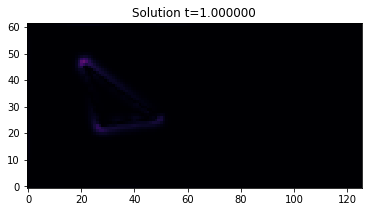

Obstacle number 1


[0] WARNING  pylbm.scheme in function _check_inverse line 384
Problem M * invM is not identity !!!


Reynolds number  2.000e+00


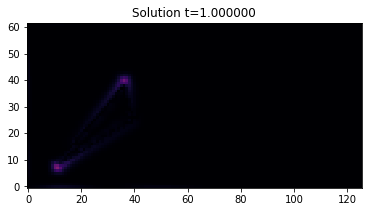

In [5]:
fig.animate(update)
fig.show()

In [7]:
from matplotlib import animation, rc
from IPython.display import HTML